In [1]:
import random
import string
import numpy as np
from deap import base, creator, tools

In [ ]:
https://medium.com/@pasdan/genetic-algorithm-the-travelling-salesman-problem-via-python-deap-f238e0dd1a73
https://github.com/pepper-johnson/sack_lunch/blob/master/Notebooks/GA/Travelling%20Salesman%20Problem%20via%20DEAP.ipynb

In [51]:
###########################
### loading the dataset ###
###########################


#load file
#And
#converting the coordinates into distances between cities
import random
import math
import tsplib95

def euclidean_2d_jitter(a, b):
    x1, y1 = a
    x2, y2 = b
    dist = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)   
    return dist * random.random() * 2

problem = tsplib95.load_problem('dj38.tsp', special=euclidean_2d_jitter)
problem.special = euclidean_2d_jitter

In [52]:
#Conveting TSP file to numpy arrays

#Comparing with original dataset from the link
random.seed(11);
np.random.seed(121);


INDIVIDUAL_SIZE = NUMBER_OF_CITIES = 38
POPULATION_SIZE = 200
N_ITERATIONS = 3000
N_MATINGS = 50

cities = list(problem.get_nodes())

#intialize emtpy arry with distances
distances = np.zeros((NUMBER_OF_CITIES, NUMBER_OF_CITIES))

for city in cities:   
    for to_city in [ i for i in cities if not i == city ]:
        distances[to_city][city] = \
            distances[city][to_city] = problem.wfunc(city,to_city)

In [6]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [7]:
toolbox = base.Toolbox()

## permutation setup for individual,
toolbox.register("indices", random.sample, range(INDIVIDUAL_SIZE), INDIVIDUAL_SIZE)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)


#The important details here are that we want to minimize the fitness (shortest path). 
#The individuals need to be setup to not repeat or skip a city. Since each city must be represented, 
#we use toolbox.indices. 
#This allows our individuals to be setup with a random.sample from the values in range(INDIVIDUAL_SIZE). 



## population setup,
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.01)
toolbox.register("select", tools.selTournament, tournsize=10)

In [8]:
#start at index 0 and iterate through the individual by collecting the distances between each point. 
#The sum of those distances becomes our fitness.

def EVALUATE(individual):
    summation = 0
    start = individual[0]
    for i in range(1, len(individual)):
        end = individual[i]
        summation += distances[start][end]
        start = end
    return summation

toolbox.register("evaluate", EVALUATE)

In [9]:
class Runner:
    
    def __init__(self, toolbox):
        self.toolbox = toolbox
        self.set_parameters(10, 5, 2)
        
    def set_parameters(self, population_size, iterations, n_matings):
        self.iterations = iterations
        self.population_size = population_size
        self.n_matings = n_matings
        
    def set_fitness(self, population):
        fitnesses = [ 
            (individual, self.toolbox.evaluate(individual)) 
            for individual in population 
        ]

        for individual, fitness in fitnesses:
            individual.fitness.values = (fitness,)
            
    def get_offspring(self, population):
        n = len(population)
        for _ in range(self.n_matings):
            i1, i2 = np.random.choice(range(n), size=2, replace=False)

            offspring1, offspring2 = \
                self.toolbox.mate(population[i1], population[i2])
            
            yield self.toolbox.mutate(offspring1)[0]
            yield self.toolbox.mutate(offspring2)[0]
    
    @staticmethod
    def pull_stats(population, iteration=1):
        fitnesses = [ individual.fitness.values[0] for individual in population ]
        return {
            'i': iteration,
            'mu': np.mean(fitnesses),
            'std': np.std(fitnesses),
            'max': np.max(fitnesses),
            'min': np.min(fitnesses)
        }  
    
    def Run(self):
        population = self.toolbox.population(n=self.population_size)
        self.set_fitness(population)
        
        stats = []
        for iteration in list(range(1, self.iterations + 1)):
            current_population = list(map(self.toolbox.clone, population))
            offspring = list(self.get_offspring(current_population))            
            for child in offspring:
                current_population.append(child)
            
            ## reset fitness,
            self.set_fitness(current_population)
            
            population[:] = self.toolbox.select(current_population, len(population))
            stats.append(
                Runner.pull_stats(population, iteration))
            
        return stats, population

In [10]:
%time
a = Runner(toolbox)
a.set_parameters(POPULATION_SIZE, N_ITERATIONS, N_MATINGS)
stats, population = a.Run()

#Total runtime: 

Wall time: 0 ns


In [11]:
stats, population = a.Run()

In [70]:
stats

[{'i': 1,
  'mu': 22108.505,
  'std': 1239.7753183440136,
  'max': 24802.0,
  'min': 19825.0},
 {'i': 2,
  'mu': 20204.005,
  'std': 556.2151067482796,
  'max': 22625.0,
  'min': 19707.0},
 {'i': 3,
  'mu': 19064.01,
  'std': 835.2859749211644,
  'max': 20144.0,
  'min': 17209.0},
 {'i': 4,
  'mu': 17863.865,
  'std': 627.5459798094479,
  'max': 19211.0,
  'min': 17010.0},
 {'i': 5,
  'mu': 17130.7,
  'std': 197.0294648015875,
  'max': 18318.0,
  'min': 16813.0},
 {'i': 6,
  'mu': 16848.525,
  'std': 242.52375012563203,
  'max': 17154.0,
  'min': 16153.0},
 {'i': 7,
  'mu': 16303.545,
  'std': 387.71064980859114,
  'max': 16998.0,
  'min': 15497.0},
 {'i': 8,
  'mu': 15468.955,
  'std': 557.7913525459139,
  'max': 16748.0,
  'min': 14082.0},
 {'i': 9,
  'mu': 14702.955,
  'std': 545.4732742994839,
  'max': 15540.0,
  'min': 14082.0},
 {'i': 10,
  'mu': 14091.545,
  'std': 185.12776122181134,
  'max': 15115.0,
  'min': 13769.0},
 {'i': 11,
  'mu': 13850.84,
  'std': 123.99888870469766,


In [71]:
population

[[9,
  8,
  13,
  15,
  24,
  22,
  25,
  29,
  21,
  14,
  10,
  1,
  2,
  0,
  35,
  37,
  33,
  34,
  36,
  31,
  27,
  18,
  17,
  16,
  12,
  11,
  19,
  28,
  32,
  30,
  26,
  23,
  20,
  6,
  7,
  5,
  3,
  4],
 [9,
  8,
  13,
  15,
  24,
  22,
  25,
  29,
  21,
  14,
  10,
  1,
  2,
  0,
  35,
  37,
  33,
  34,
  36,
  31,
  27,
  18,
  17,
  16,
  12,
  11,
  19,
  28,
  32,
  30,
  26,
  23,
  20,
  6,
  7,
  5,
  3,
  4],
 [9,
  8,
  13,
  15,
  24,
  22,
  25,
  29,
  21,
  14,
  10,
  1,
  2,
  0,
  35,
  37,
  33,
  34,
  36,
  31,
  27,
  18,
  17,
  16,
  12,
  11,
  19,
  28,
  32,
  30,
  26,
  23,
  20,
  6,
  7,
  5,
  3,
  4],
 [9,
  8,
  13,
  15,
  24,
  22,
  25,
  29,
  21,
  14,
  10,
  1,
  2,
  0,
  35,
  37,
  33,
  34,
  36,
  31,
  27,
  18,
  17,
  16,
  12,
  11,
  19,
  28,
  32,
  30,
  26,
  23,
  20,
  6,
  7,
  5,
  3,
  4],
 [9,
  8,
  13,
  15,
  24,
  22,
  25,
  29,
  21,
  14,
  10,
  1,
  2,
  0,
  35,
  37,
  33,
  34,
  36,
  31,
  27,
  1

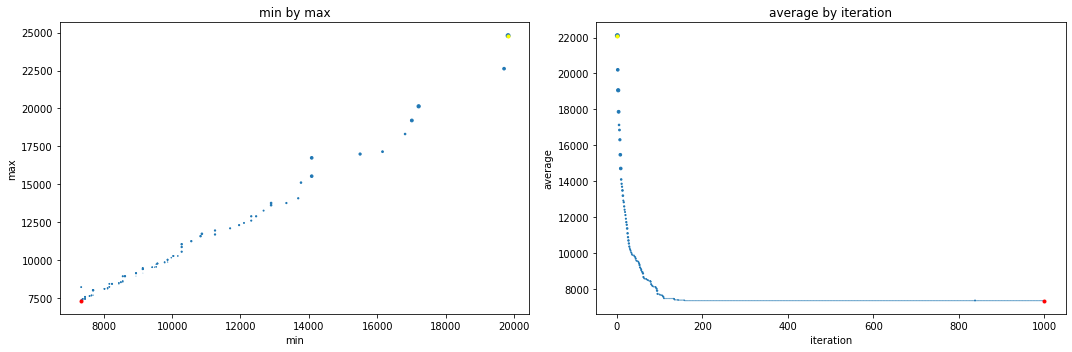

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

_ = plt.scatter([ s['min'] for s in stats ], [ s['max'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])
_ = plt.title('min by max')
_ = plt.xlabel('min')
_ = plt.ylabel('max')
_ = plt.plot(stats[0]['min'], stats[0]['max'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['min'], stats[-1]['max'], marker='.', color='red')


plt.subplot(1,2,2)

_ = plt.scatter([ s['i'] for s in stats ], [ s['mu'] for s in stats ], marker='.', s=[ (s['std'] + 1) / 20 for s in stats ])
_ = plt.title('average by iteration')
_ = plt.xlabel('iteration')
_ = plt.ylabel('average')
_ = plt.plot(stats[0]['i'], stats[0]['mu'], marker='.', color='yellow')
_ = plt.plot(stats[-1]['i'], stats[-1]['mu'], marker='.', color='red')

plt.tight_layout()
plt.show()

In [13]:
#start at index 0 and iterate through the individual by collecting the distances between each point. 
#The sum of those distances becomes our fitness.

fitnesses = sorted([ 
    (i, toolbox.evaluate(individual)) 
    for i, individual in enumerate(population) 
], key=lambda x: x[1])

fitnesses[:5]

[(0, 7341.0), (1, 7341.0), (2, 7341.0), (3, 7341.0), (4, 7341.0)]

In [94]:
result = [x+1 for x in population[0]]
print("final restult: "+ str(result))

final restult: [10, 9, 14, 16, 25, 23, 26, 30, 22, 15, 11, 2, 3, 1, 36, 38, 34, 35, 37, 32, 28, 19, 18, 17, 13, 12, 20, 29, 33, 31, 27, 24, 21, 7, 8, 6, 4, 5]
